In [7]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import functions.eddy_feedback as ef

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [8]:
data_path = '/home/links/ct715/data_storage/PAMIP/processed_daily/daily_efp_mon-avg'
models = sorted(os.listdir(data_path))

ds = {}
for model in models:
    
    path = os.path.join(data_path, model)
    files = os.path.join(path, '*.nc')
    if len(files) == 0:
        print(f'No files found for {model}')
        continue
    ds[model] = xr.open_mfdataset(files, concat_dim='ens_ax', combine='nested')
    

In [9]:
efp_data = []

for model in models:
    dataset = ds[model]
    
    if model == 'HadGEM3-GC31-LL':
        members = np.delete(dataset.ens_ax.values, [27,28])
        dataset=dataset.sel(ens_ax=members)
    
    efp_nh = ef.calculate_efp(dataset, data_type='pamip', calc_south_hemis=False)
    efp_sh = ef.calculate_efp(dataset, data_type='pamip', calc_south_hemis=True)
    
    efp_data.append({'model': model, 'efp_nh': efp_nh, 'efp_sh': efp_sh})

efp_df = pd.DataFrame(efp_data)
efp_df

,model,efp_nh,efp_sh
0,AWI-CM-1-1-MR,0.2592,0.2557
1,CNRM-CM6-1,0.2244,0.1944
2,CanESM5,0.3133,0.3271
3,FGOALS-f3-L,0.2353,0.1273
4,HadGEM3-GC31-LL,0.1735,0.1729
5,HadGEM3-GC31-MM,0.2525,0.1874
6,IPSL-CM6A-LR,0.2623,0.2015
7,MIROC6,0.1592,0.2058


#### Monthly values which are also daily:
- AWI (ECHAM): Can't compare to my monthly values. Should check Rosie's
- CNRM (daily): Pretty close!
- FGOALS (daily): Almost identical!
- IPSL (daily): Very close!
- MIROC (daily): Not that close (although monthly values have missing values)

#### Monthly values which aren't daily:
- CanESM (6h): Quite far away (~0.1)
- HadGEM-LL (20 min): 
- HadGEM-MM (20 min):

In [10]:
# efp_df.to_csv('./data/daily_efp.csv')

In [11]:
# df = efp_df[~efp_df['model'].isin(['HadGEM3-GC31-MM'])]

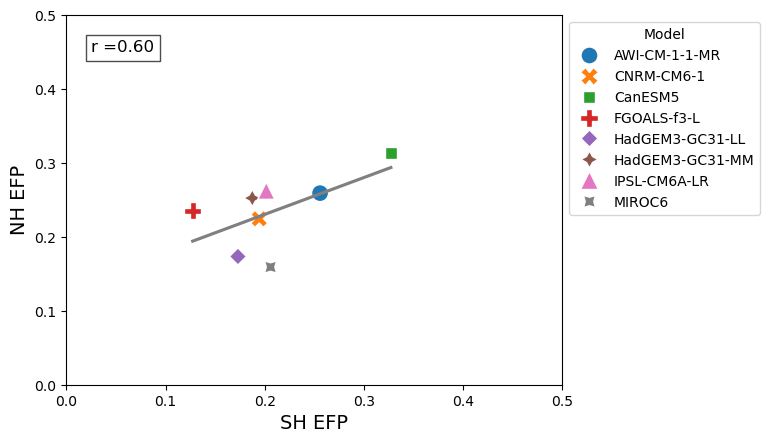

In [13]:
sns.regplot(data=efp_df, x='efp_sh', y='efp_nh', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=efp_df, x='efp_sh', y='efp_nh', hue='model', style='model', s=150)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=efp_df['efp_nh'], y=efp_df['efp_sh'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes, 
         bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

plt.ylabel('NH EFP', fontsize=14)
plt.xlabel('SH EFP', fontsize=14)
# plt.title('500 hPa EFP', fontsize=16)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

plt.legend(bbox_to_anchor=(1,1), title='Model')
# plt.savefig('./plots/500hPa_efp_NH_vs_SH.png')
plt.show()